In [1]:
!pip -q install plotly pycountry scikit-learn

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.express as px
import plotly.graph_objects as go
import pycountry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 88.9 MB/s eta 0:00:00


In [2]:
PROJECT_CSV = Path("climate_related_projects2_merged2 - Sheet1.csv")
GDP_CSV     = Path("API_NY.GDP.MKTP.CD_DS2_en_excel_v2_131991(1) - Data.csv")

projects_raw = pd.read_csv(PROJECT_CSV)
gdp_raw      = pd.read_csv(GDP_CSV)

gdp_raw["2023"] = pd.to_numeric(gdp_raw["2023"], errors="coerce")

# ISO‑3 → ISO‑2 mapping via pycountry
iso3_to2 = {c.alpha_3: c.alpha_2 for c in pycountry.countries if hasattr(c, "alpha_3")}
gdp_raw["iso2"] = gdp_raw["Country Code"].map(iso3_to2)

EU_ISO2 = [
    "AT","BE","BG","HR","CY","CZ","DK","EE","FI","FR","DE","GR","HU","IE",
    "IT","LV","LT","LU","MT","NL","PL","PT","RO","SK","SI","ES","SE"
]

In [3]:
projects_raw['status'].unique()

array(['CLOSED', 'SIGNED', 'TERMINATED'], dtype=object)

In [ ]:
def to_float_eu(x):
    if pd.isna(x):
        return np.nan
    s = str(x).replace("€", "").replace(" ", "").replace(" ", "")
    if "," in s and "." in s:
        if s.find(",") > s.find("."):
            s = s.replace(".", "").replace(",", ".")
        else:
            s = s.replace(",", "")
    elif "," in s:
        s = s.replace(".", "").replace(",", ".")
    else:
        s = s.replace(",", "")
    try:
        return float(s)
    except ValueError:
        return np.nan

In [ ]:
def country_features(projects: pd.DataFrame, gdp: pd.DataFrame) -> pd.DataFrame:
    money_cols = [
        "ecContribution", "netEcContribution", "organisationTotalCost",
        "projectTotalCost", "ecMaxContribution"
    ]
    for col in money_cols:
        projects[col] = projects[col].apply(to_float_eu)

    # Collaboration flag
    collab_map = projects.groupby("projectID")["country"].nunique()
    projects["is_collab"] = projects["projectID"].isin(collab_map[collab_map > 1].index)

    grp = projects.groupby("country")
    df = pd.DataFrame({
        "total_ec_contribution": grp["ecContribution"].sum(),
        "total_projects":        grp["projectID"].nunique(),
        "unique_orgs":           grp["organisationID"].nunique(),
        "collab_project_ratio":  grp["is_collab"].mean(),
        "signed_pct":            grp.apply(lambda g: g["status"].str.upper().eq("SIGNED").mean()),
        "closed_pct":            grp.apply(lambda g: g["status"].str.upper().eq("CLOSED").mean()),
        "terminated_pct":        grp.apply(lambda g: g["status"].str.upper().eq("TERMINATED").mean()),
    }).reset_index()

    df["success_ratio"] = (df["signed_pct"] + df["closed_pct"]) - df["terminated_pct"]

    gdp_eu = gdp[["iso2", "2023"]].rename(columns={"iso2": "country", "2023": "gdp_2023"})
    df = df.merge(gdp_eu, on="country", how="left")
    df = df[df["country"].isin(EU_ISO2)]

    df["ec_per_gdp"] = df["total_ec_contribution"] / df["gdp_2023"]
    df.fillna(0, inplace=True)

    # New enriched score components
    df["funding_share"] = df["total_ec_contribution"] / df["total_ec_contribution"].sum()
    df["project_share"] = df["total_projects"] / df["total_projects"].max()
    df["org_share"]     = df["unique_orgs"] / df["unique_orgs"].max()

    # Use all factors
    metric_cols = [
        "funding_share", "ec_per_gdp", "project_share", "org_share",
        "collab_project_ratio", "success_ratio"
    ]

    scaler = MinMaxScaler()
    df[[m + "_scaled" for m in metric_cols]] = scaler.fit_transform(df[metric_cols])
    scaled_cols = [m + "_scaled" for m in metric_cols]
    df["Score"] = df[scaled_cols].mean(axis=1)

    return df

In [ ]:
features = country_features(projects_raw, gdp_raw)
print("Feature rows:", len(features))


<ipython-input-68-e33550f14615>:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  "signed_pct":            grp.apply(lambda g: g["status"].str.upper().eq("SIGNED").mean()),
<ipython-input-68-e33550f14615>:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  "closed_pct":            grp.apply(lambda g: g["status"].str.upper().eq("CLOSED").mean()),


Feature rows: 26


<ipython-input-68-e33550f14615>:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  "terminated_pct":        grp.apply(lambda g: g["status"].str.upper().eq("TERMINATED").mean()),


In [ ]:
features

,country,total_ec_contribution,total_projects,unique_orgs,collab_project_ratio,signed_pct,closed_pct,terminated_pct,success_ratio,gdp_2023,...,funding_share,project_share,org_share,funding_share_scaled,ec_per_gdp_scaled,project_share_scaled,org_share_scaled,collab_project_ratio_scaled,success_ratio_scaled,Score
5,AT,5.453557e+08,744,477,0.978452,0.992817,0.005587,0.001596,0.996808,5.116852e+11,...,0.037932,0.375568,0.292459,0.240398,0.242762,0.359067,0.280997,0.805061,0.904230,0.472086
10,BE,1.614050e+09,1342,747,0.972576,0.992448,0.004769,0.002782,0.994436,6.447828e+11,...,0.112265,0.677436,0.458001,0.723992,0.663725,0.668912,0.449221,0.732413,0.833068,0.678555
12,BG,8.788603e+07,185,172,0.913333,0.920000,0.080000,0.000000,1.000000,1.024077e+11,...,0.006113,0.093387,0.105457,0.033389,0.181964,0.069430,0.090966,0.000000,1.000000,0.229291
31,CY,1.237384e+08,257,129,0.988858,0.997214,0.002786,0.000000,1.000000,3.388693e+10,...,0.008607,0.129732,0.079093,0.049613,1.000000,0.106736,0.064174,0.933713,1.000000,0.525706
32,CZ,1.518115e+08,356,195,0.968619,0.979079,0.010460,0.010460,0.979079,3.432079e+11,...,0.010559,0.179707,0.119559,0.062316,0.060175,0.158031,0.105296,0.683501,0.372385,0.240284
33,DE,2.223998e+09,1981,1508,0.957074,0.992153,0.004616,0.003231,0.993538,4.525704e+12,...,0.154690,1.000000,0.924586,1.000000,0.074550,1.000000,0.923364,0.540762,0.806139,0.724136
35,DK,5.253244e+08,683,328,0.940037,0.988930,0.006458,0.004613,0.990775,4.070919e+11,...,0.036539,0.344775,0.201104,0.231334,0.308546,0.327461,0.188162,0.330137,0.723247,0.351481
39,EE,9.683564e+07,189,102,0.963710,0.995968,0.004032,0.000000,1.000000,4.129125e+10,...,0.006735,0.095406,0.062538,0.037439,0.617436,0.071503,0.047352,0.622804,1.000000,0.399422
42,ES,1.993671e+09,1889,1631,0.956912,0.984685,0.011844,0.003472,0.993057,1.620091e+12,...,0.138669,0.953559,1.000000,0.895775,0.291022,0.952332,1.000000,0.538769,0.791709,0.744934
44,FI,5.162743e+08,573,320,0.982922,0.999051,0.000949,0.000000,1.000000,2.955323e+11,...,0.035909,0.289248,0.196199,0.227239,0.442234,0.270466,0.183178,0.860329,1.000000,0.497241


In [ ]:
df=features
import plotly.express as px

bar_fig = px.bar(df.sort_values("Score", ascending=False),
                 x="country", y="Score",
                 title="EU country performance score ranking")
bar_fig.update_layout(xaxis_title="Country", yaxis_title="Score (0–1)")
bar_fig.show()

In [ ]:
import plotly.express as px
import json

# Assign colors based on quantile bins for score
quantiles = pd.qcut(df["Score"], q=5, labels=False)
color_map = px.colors.sequential.Viridis
df["color"] = quantiles.map(lambda q: color_map[q])

bar_fig = px.bar(df.sort_values("Score", ascending=False),
                 x="country", y="Score", color="Score",
                 color_continuous_scale="Viridis",
                 title="EU country performance score ranking")
bar_fig.update_layout(xaxis_title="Country", yaxis_title="Score (0–1)")
bar_fig.show()

# Export JSON
json_data = df.sort_values("Score", ascending=False)[["country", "Score", "color"]].to_dict(orient="records")
with open("eu_scores_colored.json", "w") as f:
    json.dump(json_data, f, indent=2)

print("Exported to eu_scores_colored.json")


Exported to eu_scores_colored.json


In [ ]:

def compute_weighted_scores_and_tabnet_insights(df):
    import plotly.express as px
    import plotly.graph_objects as go
    import json
    from pytorch_tabnet.tab_model import TabNetRegressor
    from sklearn.model_selection import train_test_split
    from sklearn.manifold import TSNE
    import torch
    from sklearn.preprocessing import MinMaxScaler
    import pandas as pd

    # Assign weights for weighted score
    weights = {
        "funding_share_scaled": 0.20,
        "ec_per_gdp_scaled": 0.20,
        "project_share_scaled": 0.15,
        "org_share_scaled": 0.15,
        "collab_project_ratio_scaled": 0.15,
        "success_ratio_scaled": 0.15
    }

    if "Score" not in df.columns:
        scaled_cols = list(weights.keys())
        df["Score"] = df[scaled_cols].mean(axis=1)

    df["Weighted_Score"] = sum(df[col] * w for col, w in weights.items())

    features_list = [
        "funding_share", "ec_per_gdp", "project_share", "org_share",
        "collab_project_ratio", "success_ratio"
    ]
    tabnet_X = df[features_list].values.astype("float32")

    # Train TabNet on Weighted Score
    print("\nTabNet trained on Weighted Score")
    tabnet_y_w = df["Weighted_Score"].values.astype("float32").reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(tabnet_X, tabnet_y_w, test_size=0.2, random_state=42)
    clf_weighted = TabNetRegressor(seed=42, verbose=0)
    clf_weighted.fit(X_train=X_train, y_train=y_train, eval_set=[(X_test, y_test)], max_epochs=500, patience=50)

    imp_w = clf_weighted.feature_importances_
    print("\nFeature Importances (Weighted Score):")
    for name, imp in zip(features_list, imp_w):
        print(f"{name:>25}: {imp:.4f}")

    # Visualise importances
    fig_w = px.bar(x=features_list, y=imp_w, title="TabNet Feature Importances – Weighted Score")
    fig_w.update_layout(yaxis_title="Importance", xaxis_title="Feature")
    fig_w.show()

    # Train TabNet on Equal-weight Score
    print("\nTabNet trained on Equal-weight Score")
    tabnet_y_e = df["Score"].values.astype("float32").reshape(-1, 1)
    X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(tabnet_X, tabnet_y_e, test_size=0.2, random_state=42)
    clf_equal = TabNetRegressor(seed=0, verbose=0)
    clf_equal.fit(X_train=X_train_e, y_train=y_train_e, eval_set=[(X_test_e, y_test_e)], max_epochs=500, patience=50)

    imp_e = clf_equal.feature_importances_
    print("\nFeature Importances (Equal-weight Score):")
    for name, imp in zip(features_list, imp_e):
        print(f"{name:>25}: {imp:.4f}")

    fig_e = px.bar(x=features_list, y=imp_e, title="TabNet Feature Importances – Equal-weight Score")
    fig_e.update_layout(yaxis_title="Importance", xaxis_title="Feature")
    fig_e.show()

    # Optional: TabNet embeddings for advanced analysis (clustering, projection)
    with torch.no_grad():
        clf_weighted.network.eval()
        embeddings = clf_weighted.network.embedder.forward(torch.from_numpy(tabnet_X)).detach().cpu().numpy()

    # 2D projection using t-SNE with safe perplexity
    perplexity = min(5, len(embeddings) - 1)
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    coords = tsne.fit_transform(embeddings)
    df["x_tsne"] = coords[:, 0]
    df["y_tsne"] = coords[:, 1]

    tsne_fig = px.scatter(df, x="x_tsne", y="y_tsne", color="Weighted_Score",
                          title="TabNet Embeddings (t-SNE Projection)",
                          hover_name="country", color_continuous_scale="Viridis")
    tsne_fig.show()

    # Export JSON
    quantiles = pd.qcut(df["Weighted_Score"], q=5, labels=False)
    color_map = px.colors.sequential.Viridis
    df["color"] = quantiles.map(lambda q: color_map[q])

    bar_fig = px.bar(df.sort_values("Weighted_Score", ascending=False),
                     x="country", y="Weighted_Score", color="Weighted_Score",
                     color_continuous_scale="Viridis",
                     title="EU country weighted performance score ranking")
    bar_fig.update_layout(xaxis_title="Country", yaxis_title="Weighted Score (0–1)")
    bar_fig.show()

    json_data = df.sort_values("Weighted_Score", ascending=False)[["country", "Weighted_Score", "color"]].to_dict(orient="records")
    with open("eu_scores_weighted_colored.json", "w") as f:
        json.dump(json_data, f, indent=2)

    print("Exported to eu_scores_weighted_colored.json")




In [ ]:
features = country_features(projects_raw, gdp_raw)
compute_weighted_scores_and_tabnet_insights(features)

<ipython-input-68-e33550f14615>:19: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-68-e33550f14615>:20: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-68-e33550f14615>:21: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass


TabNet trained on Weighted Score

Early stopping occurred at epoch 50 with best_epoch = 0 and best_val_0_mse = 1.7825

Feature Importances (Weighted Score):
            funding_share: 0.1933
               ec_per_gdp: 0.0105
            project_share: 0.2462
                org_share: 0.3987
     collab_project_ratio: 0.0869
            success_ratio: 0.0644


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning:

Best weights from best epoch are automatically used!




TabNet trained on Equal-weight Score

Early stopping occurred at epoch 50 with best_epoch = 0 and best_val_0_mse = 0.12253

Feature Importances (Equal-weight Score):
            funding_share: 0.0158
               ec_per_gdp: 0.2837
            project_share: 0.2017
                org_share: 0.0459
     collab_project_ratio: 0.2564
            success_ratio: 0.1966


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning:

Best weights from best epoch are automatically used!



Exported to eu_scores_weighted_colored.json


In [ ]:

def cluster_objectives_with_bert(project_df):
    import pandas as pd
    import json
    from sklearn.cluster import KMeans
    from sentence_transformers import SentenceTransformer
    from sklearn.feature_extraction.text import CountVectorizer
    from collections import Counter

    text_data = project_df["objective"].dropna().astype(str).tolist()
    if len(text_data) < 5:
        print("Not enough objectives to cluster meaningfully.")
        return

    model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = model.encode(text_data, show_progress_bar=True)

    # Determine number of clusters using heuristic
    k = min(8, max(2, len(text_data) // 25))
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(embeddings)

    # Assign cluster labels to original texts
    clustered_texts = pd.DataFrame({"text": text_data, "cluster": labels})

    # Extract top words per cluster
    vectorizer = CountVectorizer(stop_words="english")
    counts = vectorizer.fit_transform(clustered_texts["text"])
    terms = vectorizer.get_feature_names_out()

    wordcloud_data = []
    for cluster_id in sorted(clustered_texts["cluster"].unique()):
        row_idx = clustered_texts[clustered_texts["cluster"] == cluster_id].index
        cluster_counts = counts[row_idx]
        word_freq = cluster_counts.sum(axis=0).A1
        top_words = [terms[i] for i in word_freq.argsort()[::-1][:15]]
        for word in top_words:
            wordcloud_data.append({"topic": f"topic_{cluster_id}", "word": word})

    with open("objective_topics_wordcloud.json", "w") as f:
        json.dump(wordcloud_data, f, indent=2)

    print("Exported BERT-based word cloud topic data to objective_topics_wordcloud.json")



In [ ]:
cluster_objectives_with_bert(projects_raw)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1293 [00:00<?, ?it/s]

Exported BERT-based word cloud topic data to objective_topics_wordcloud.json


In [4]:
df=projects_raw

In [7]:
from keybert import KeyBERT
from tqdm import tqdm
from collections import defaultdict, Counter

# Load unique objectives
unique_df = (
    df.dropna(subset=["objective"])
      .drop_duplicates(subset=["projectID"])
      .sort_values("projectID")[["projectID", "objective"]]
      .astype(str)
)

objectives = unique_df["objective"].tolist()
project_ids = unique_df["projectID"].tolist()

# Load BERT model
model = KeyBERT("all-MiniLM-L6-v2")

# Define climate-related filter keywords
climate_keywords = ["climate", "carbon", "emission", "neutral", "warming", "co2", "sustainab", "net zero", "decarbon", "biodiversity", "resilience"]

# Extract & filter keyphrases
project_keyphrases = defaultdict(list)

for pid, obj in tqdm(zip(project_ids, objectives), total=len(objectives), desc="Extracting filtered keyphrases"):
    phrases = model.extract_keywords(
        obj,
        keyphrase_ngram_range=(1, 3),
        stop_words='english',
        top_n=5,
        use_maxsum=True
    )
    for phrase, _ in phrases:
        phrase_lower = phrase.lower()
        if any(k in phrase_lower for k in climate_keywords):
            project_keyphrases[pid].append(phrase_lower)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Extracting filtered keyphrases: 100%|██████████| 3784/3784 [2:12:14<00:00,  2.10s/it]


In [8]:
project_keyphrases

defaultdict(list,
            {'101039066': ['forests support biodiversity',
              'reproduction trajectories climate'],
             '101039376': ['sustainability influx'],
             '101039402': ['sustainable communities hunger'],
             '101039426': ['climate action pathways'],
             '101039567': ['forest co2 sequestration', 'climate forests key'],
             '101039588': ['warming arctic following',
              'warming accelerating arctic',
              'soil co2 release',
              'plant soil carbon',
              'rooting ecosystem carbon'],
             '101039648': ['litigation climate change'],
             '101039716': ['carbon feedbacks soil'],
             '101040461': ['reconstruct co2',
              'past climate data',
              'resolution co2',
              'data collection carbonates',
              'ocean carbon flux'],
             '101040625': ['climate evolution earth',
              'water saturation co2',
              '

In [9]:
import json
from collections import defaultdict

project_keyphrases_dict = dict(project_keyphrases)


with open("project_keyphrases_filtered.json", "w") as f:
    json.dump(project_keyphrases_dict, f, indent=2)


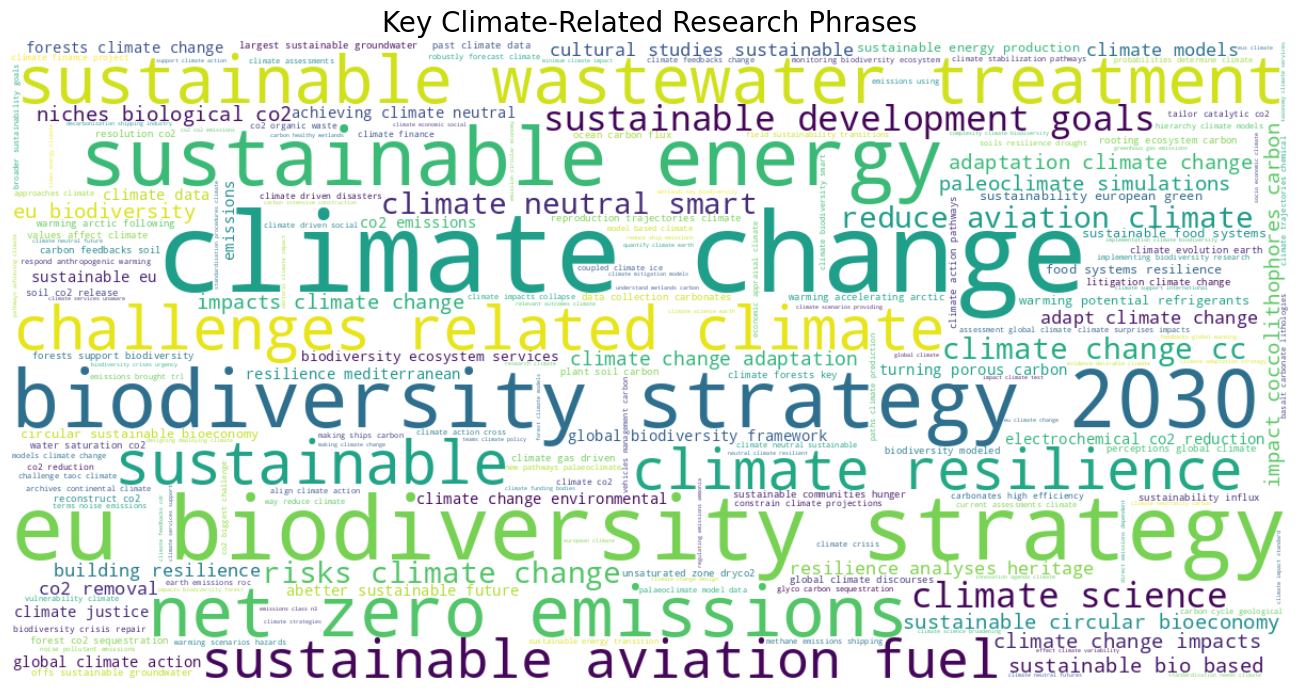

In [10]:
from collections import defaultdict, Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt



all_phrases = [phrase for phrases in project_keyphrases.values() for phrase in phrases]


phrase_freq = Counter(all_phrases)

wordcloud = WordCloud(width=1200, height=600, background_color='white',
                      colormap='viridis').generate_from_frequencies(phrase_freq)


plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Key Climate-Related Research Phrases", fontsize=20)
plt.tight_layout()
plt.show()
